#  House Prices: Advanced Regression Techniques

캐글의 고정된 코드로 비교적 최신에 업로드된 코드이다.
* [House Prices Prediction using TensorFlow Decision Forests](https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf)






In [ ]:
pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 가져오기

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


## 데이터세트 불러오기

In [ ]:
train_file_path = "/content/drive/MyDrive/Kaggle_study/House_Prices_Pred/data/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("학습 데이터세트 크기 : ", dataset_df.shape)
dataset_df.head(5)

학습 데이터세트 크기 :  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<ipython-input-50-9b65961246b5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = dataset_df.corr()


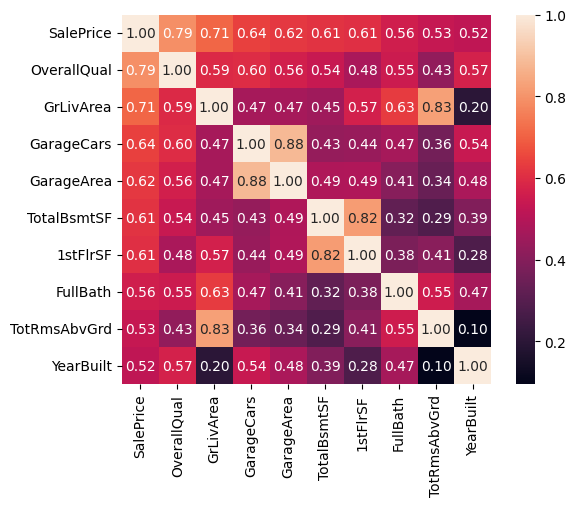

In [ ]:
#correlation matrix
corrmat = dataset_df.corr()
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # 관련도가 높은 순으로 정
cm = np.corrcoef(dataset_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, \
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

OverallQual: 주택의 전반적인 품질을 나타내는 범주형 변수입니다.
GrLivArea: 1층 거실 공간의 평방 피트입니다.
GarageCars: 차고에 들어갈 수 있는 자동차의 수입니다.
GarageArea: 차고의 평방 피트입니다.
TotalBsmtSF: 지하실의 평방 피트입니다.
1stFlrSF: 1층의 평방피트입니다.
FullBath: 집에 있는 전체 욕실의 수입니다.
TotRmsAbvGrd: 지상 위의 총 객실 수입니다.
YearBuilt: 집이 지어진 연도입니다.

### 데이터의 ID를 제거하고 정답데이터로 사용할 SalePrice를 확인해보자.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Figure size 900x800 with 0 Axes>

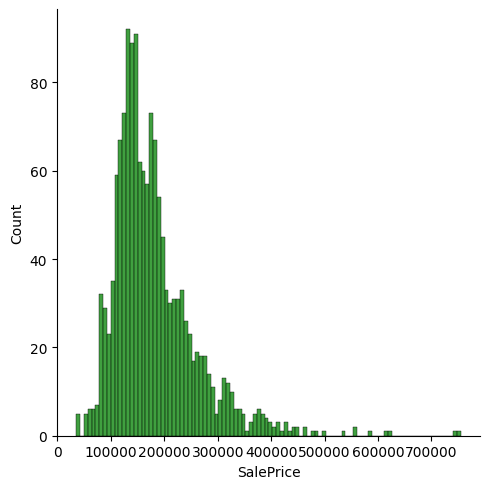

In [ ]:
# 데이터 프레임에서 id제거
dataset_df = dataset_df.drop('Id', axis=1)

# 데이터 프레임에서 가격 분포확인
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.displot(dataset_df['SalePrice'], color='g', bins=100, rug_kws={'alpha': 0.4});

## 수치 데이터 분포


In [ ]:
# 데이터 프레임의 모든 유형을 확인한다.
# .dtypes을 확인하고, .tolist 데이터를 나열, set() 중복을 제거.
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

* `int64`, `Object`와 `float64`가 있다. 이 중에서 `int64`와 `float64`

In [ ]:
df_num = dataset_df.select_dtypes(include=['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


수치 특성에 대한 분포를 플로팅해 보겠습니다.

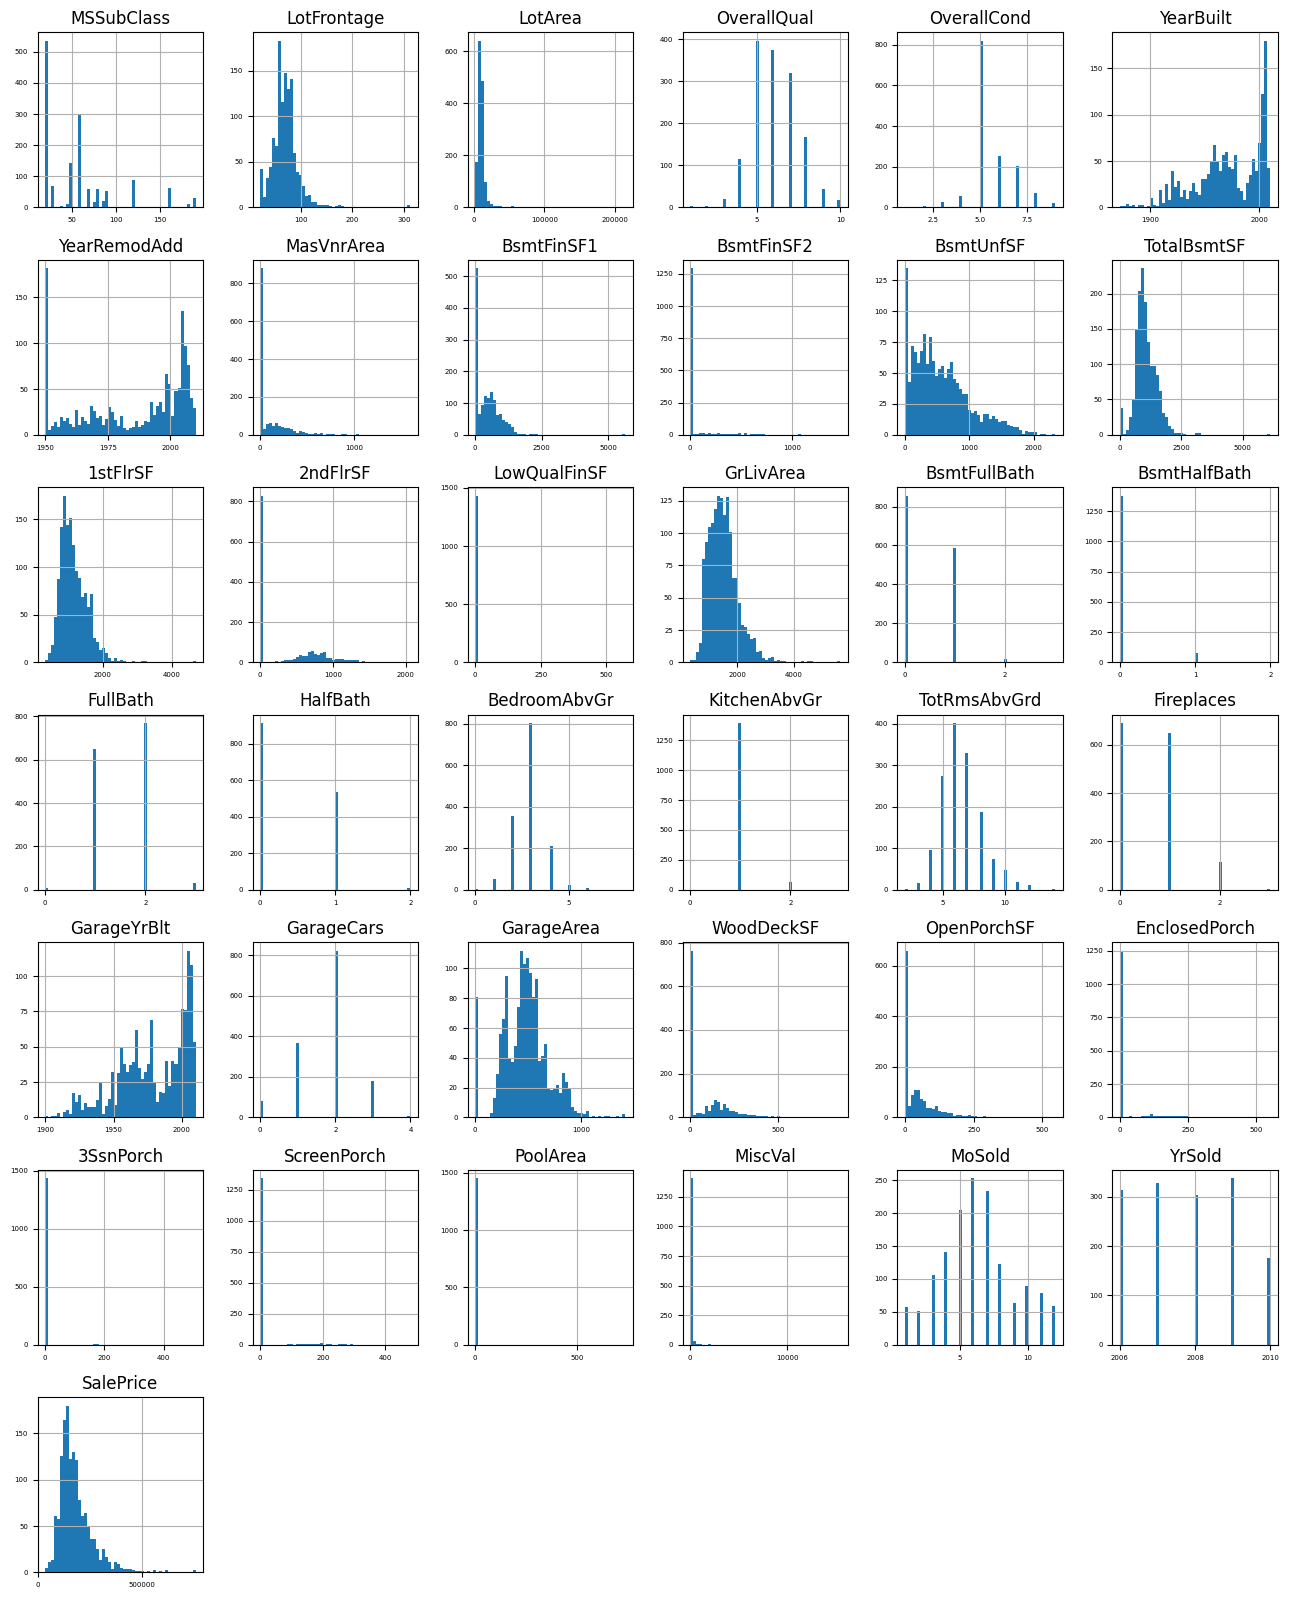

In [ ]:
df_num.hist(figsize=(16,20), bins=50, xlabelsize=5, ylabelsize=5)
plt.show()

## 데이터 세트 준비


In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} 훈력집합, {} 검증집합.".format(
    train_ds_pd.shape, valid_ds_pd.shape))

(987, 80) examples in training, (473, 80) examples in testing.


1460길이의 검증데이터 비율인 0.3만큼의 데이터가 불리언 값으로 `test_indices`에 저장되고, dataset에 `~`불리언값의 반대값이 훈련 집합에 그리고 나머지는 검증집합에 저장된다.


In [ ]:
label = "SalePrice"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

## 모델 선택
Decision Forest에는 이와 같은 모델이 있다.
* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel


In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### 랜덤 포레스트 생성

In [ ]:
# @tf.autograph.experimental.do_not_convert # 데코레이터?
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])
rf.fit(x=train_ds)

Use /tmp/tmp9q9hn6sc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.617567. Found 987 examples.
Training model...
Model trained in 0:00:01.903193
Compiling model...
Model compiled.


In [65]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=1)

### OOB(Out of Bag) 데이터 및 유효성 검사 데이터 세트에서 모델 평가
 Out of Bag(OOB) 점수를 사용하여 RandomForestModel을 검증

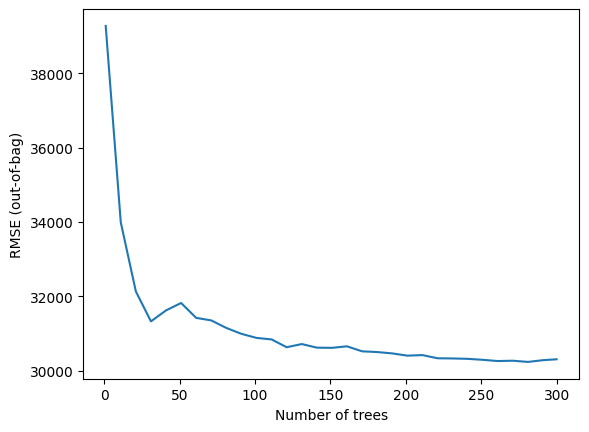

In [ ]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 282ms/step - loss: 0.0000e+00 - mse: 832059520.0000
loss: 0.0000
mse: 832059520.0000


In [ ]:
test_file_path = "/content/drive/MyDrive/Kaggle_study/House_Prices_Pred/data/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 21ms/step


,Id,SalePrice
0,1461,127297.460938
1,1462,153245.984375
2,1463,176218.421875
3,1464,183371.125000
4,1465,198084.843750
